In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint
from sklearn import mixture as mix
from pykalman import KalmanFilter
import statsmodels.api as sm
import ffn

sns.set(style='white')
# Retrieve intraday price data and combine them into a DataFrame.
# 1. Load downloaded prices from folder into a list of dataframes.
folder_path = 'STATICS/PRICE'
file_names  = ['RYAAY.csv','RYA.csv']
tickers     = [name.split('.')[0] for name in file_names]
df_list     = [pd.read_csv(os.path.join('STATICS/PRICE', name)) for name in file_names]

/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# 2. Replace the closing price column name by the ticker.
for i in range(len(df_list)):
    df_list[i].rename(columns={'close': tickers[i]}, inplace=True)

# 3. Merge all price dataframes
df  = reduce(lambda x, y: pd.merge(x, y, on='date'), df_list)

df.set_index('date',inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,RYAAY,RYA
date,,
2018-07-25 13:30:00,105.150,16.535646
2018-07-25 13:31:00,104.625,16.534656
2018-07-25 13:32:00,104.630,16.533054
2018-07-25 13:33:00,105.170,16.532205
2018-07-25 13:34:00,105.030,16.531640


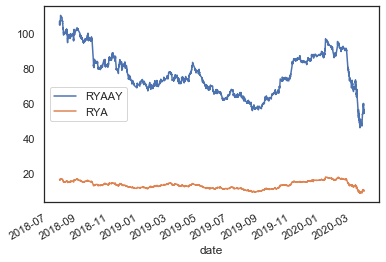

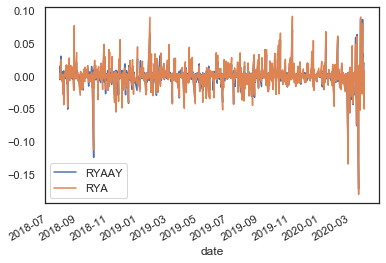

In [3]:
df.describe()
df.plot()
returns =  df.pct_change()
returns.plot()


/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


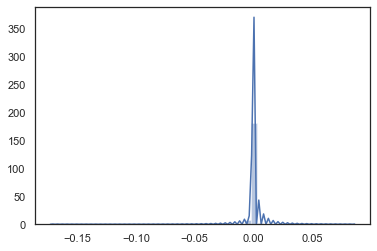

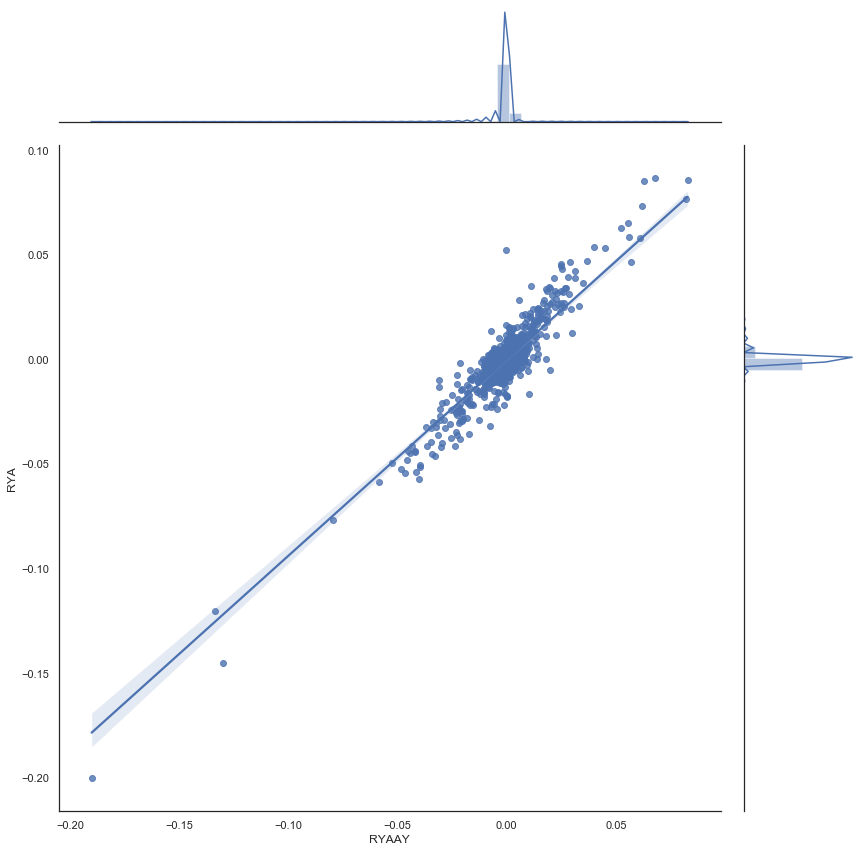

In [4]:
sns.distplot(returns.iloc[:,0:1])

log_ret_RYAAY = np.log(df['RYAAY']) - np.log(df['RYAAY'].shift(1)) 
log_ret_RYA = np.log(df['RYA']) - np.log(df['RYA'].shift(1))

#Plot using Seaborn's jointplot function
sns.jointplot(log_ret_RYAAY, log_ret_RYA, kind='reg', size=12)

In [7]:
score, pvalue, _ = coint(df['RYAAY'],df['RYA'])
print(pvalue)
print(df['RYAAY'].corr(df['RYA']))

0.25975801213913563
0.9329432080566061


In [8]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
  
    kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
     initial_state_mean=[0,0],
     initial_state_covariance=np.ones((2, 2)),
     transition_matrices=np.eye(2),
     observation_matrices=obs_mat,
     observation_covariance=2,
     transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [9]:
def backtest(s1, s2, x, y):
    #############################################################
    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio
    # CAGR: CAGR
    # run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    
    # calculate half life
    halflife = half_life(df1['spread'])
    # calculate z-score with window = half life period
    
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0
    #set up num units long
    
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    
    # Boolean whether transaction occurred
    df1['transaction'] = df1.numUnits.shift(1) != df1.numUnits
    df1['transaction'][0] = False
    
    # Cost of transaction
    df1['tradecosts'] = (df1['transaction']) * 0.0063
    
    # Save hr during holding period
    df1['hr_memory'] = np.nan
    df1['hr_memory'][df1['transaction'] & df1['numUnits'] != 0] = df1.hr[df1['transaction'] & df1['numUnits'] != 0]
    df1['hr_memory'].fillna(method='ffill',inplace=True)
    
    # Save investment amount during holding period
    df1['invest_memory'] = np.nan
    df1['invest_memory'][df1['transaction'] & df1['numUnits'] != 0] = ((df1['x'] * abs(df1['hr'])) + df1['y'])[df1['transaction'] & df1['numUnits'] != 0]
    df1['invest_memory'].fillna(method='ffill',inplace=True)
    
    df1['spreadmemory'] = df1.y + (df1.x * df1.hr_memory)
    
    df1['spread pct ch'] = (df1['spreadmemory'] - df1['spreadmemory'].shift(1)) / df1['invest_memory']
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) - (df1['tradecosts'] /df1['invest_memory'])

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    name = "bt"+ s1 + "-" + s2 + ".csv"
    df1.to_csv(name)

    return df1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

out = backtest('rya','ryaay',df['RYA'],df['RYAAY'])


In [ ]:
out['cum rets'][0] = 1
perf =out['cum rets'].calc_stats()
perf.set_riskfree_rate(0.0016)
perf.display()

In [ ]:
plt.plot(out['cum rets'])

In [ ]:
def plot_signals(d, fromDate, toDate):
    
    #idx = pd.date_range(fromDate,toDate, freq="1min")

    d = d[fromDate:toDate]
    #d = d.reindex(idx, fill_value= np.nan)
    d.index = d.index.map(str)
    # Plot the prices and buy and sell signals from z score
    
    
    S = d.y - d.x * 5

    S.plot(color='b')
    
    buyS = 0*S.copy()
    sellS = 0*S.copy()
    exitL = 0*S.copy()
    exitS = 0*S.copy()
    
    longentry = d['long entry'] * d.transaction * (d.numUnits == 1)
    longexit = d['long exit'] * d.transaction * (d.numUnits.shift(1) == 1)
    shortentry = d['short entry'] * d.transaction * (d.numUnits == -1)
    shortexit = d['short exit'] * d.transaction * (d.numUnits.shift(1) == -1)
    
    buyS[longentry] = S[longentry]
    sellS[shortentry] = S[shortentry]
    exitL[longexit] = S[longexit]
    exitS[shortexit] = S[shortexit]
    
    buyS.plot(color='g', linestyle='None', marker='o')
    sellS.plot(color='r', linestyle='None', marker='o')
    exitL.plot(color='g', linestyle='None', marker='x')
    exitS.plot(color='r', linestyle='None', marker='x')
    
    x1,x2,y1,y2 = plt.axis()

    plt.axis((x1,x2,S.min(),S.max()))

    plt.legend(['LOP Spread', 'Enter Long', 'Enter Short','Exit Long', 'Exit Short'])
    plt.xticks(rotation=45, ha="right")
    
    plt.show()
    
    
    print('{} percent return in time window'.format(round(d['port rets'].sum() *100,2)))
    

In [ ]:
plot_signals(out,"2020-01-01","2020-12-31")